* Desenvolva o Pipeline completo de um projeto de Aprendizado de Máquina, desde a Análise e preparação dos dados adquiridos até a disponibilização do algoritmo no GitHub.

* é disponibilizado seis (6) arquivos com extensão .npy. Sabe-se que cada arquivo foi adquirido por um sensor, os dados são oriundos de uma máquina com motor elétrico, os quais foram aquisitados a uma taxa de 10 KHz. Os dados de todos os sensores, foram adquiridos de forma simultânea, ou seja, no mesmo instante de tempo. O arquivo Classes.npy possui diferentes estados de funcionamento dessa máquina, podendo ou não possuir diferentes falhas e/ou funcionamento normal.

* Link para o drive com os dados: https://drive.google.com/drive/folders/1ztWi2pHqbbIU-wMMTydq9vssuJmWFPjS

OBS: sensores, são dispositivos capazes de medir grandezas físicas, tem seu funcionamento com base em sinais elétricos, em ambiente industrial podem captar sinais de ruídos e até mesmo entrarem em falha.

In [1]:
!pip install scipy

In [2]:
import numpy as np
from utils import plot
from utils import dataProcessing as dataP
import json

# Dataset
* Informações sobre as Classes
* definições do dataset

In [3]:
n_sensors = 5
classes_data = np.load('./dataset/raw/Classes.npy', allow_pickle=True)
n_samples = len(classes_data)
classes_k, counts = np.unique(classes_data, return_counts=True)

In [4]:
print(f'Total de amostras: {n_samples}')
print('Amostras por classe:')
for k, c in zip(classes_k, counts):
    print(f'\t{k}: {c}')

Total de amostras: 50000
Amostras por classe:
	Classe A: 10000
	Classe B: 10000
	Classe C: 10000
	Classe D: 10000
	Classe E: 10000


# Exploração dos Dados

In [5]:
sensor_data = []
for i in range(n_sensors):
    sensor_data.append(np.load(f'./dataset/raw/Dados_{i+1}.npy', allow_pickle=True))

* Os dados possuem capturas falhas?

In [6]:
for i, s in enumerate(sensor_data):
    print(f'Sensor s{i} contém NaN? {np.isnan(s).any()}')

Sensor s0 contém NaN? True
Sensor s1 contém NaN? True
Sensor s2 contém NaN? True
Sensor s3 contém NaN? True
Sensor s4 contém NaN? True


## Dados dos Sensores
* Estudo com samples reduzidas

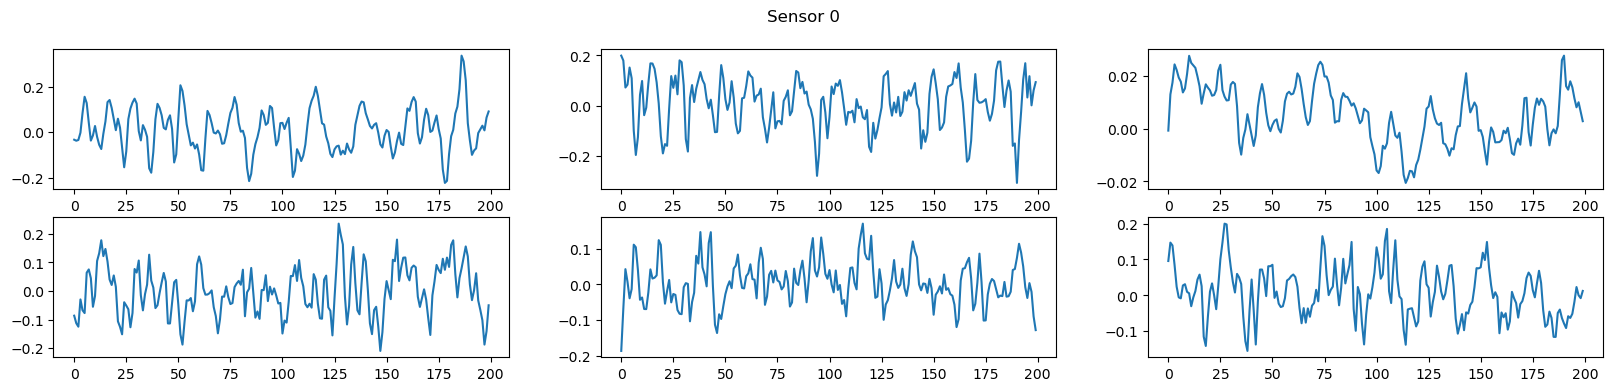

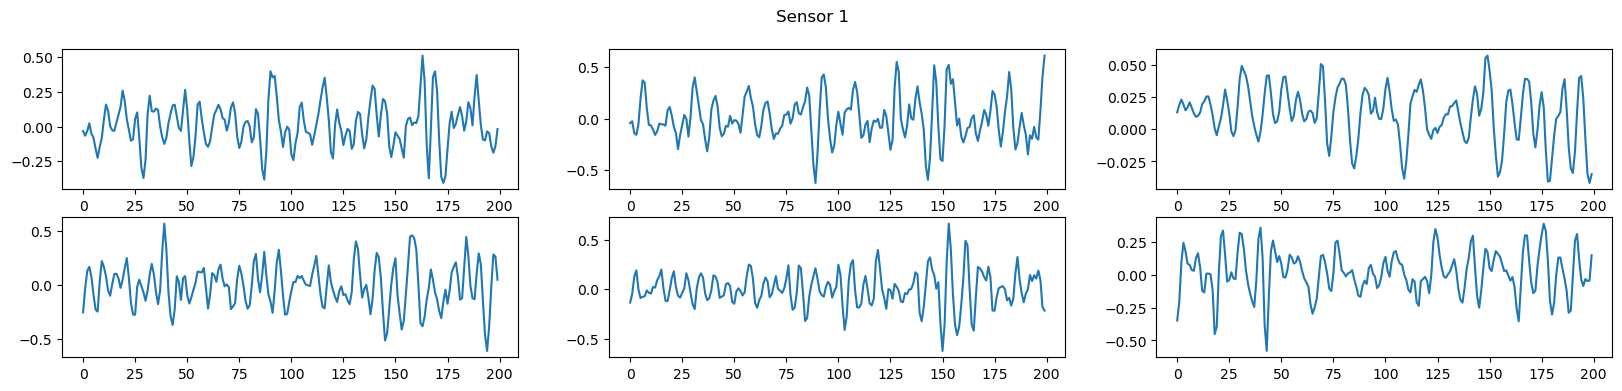

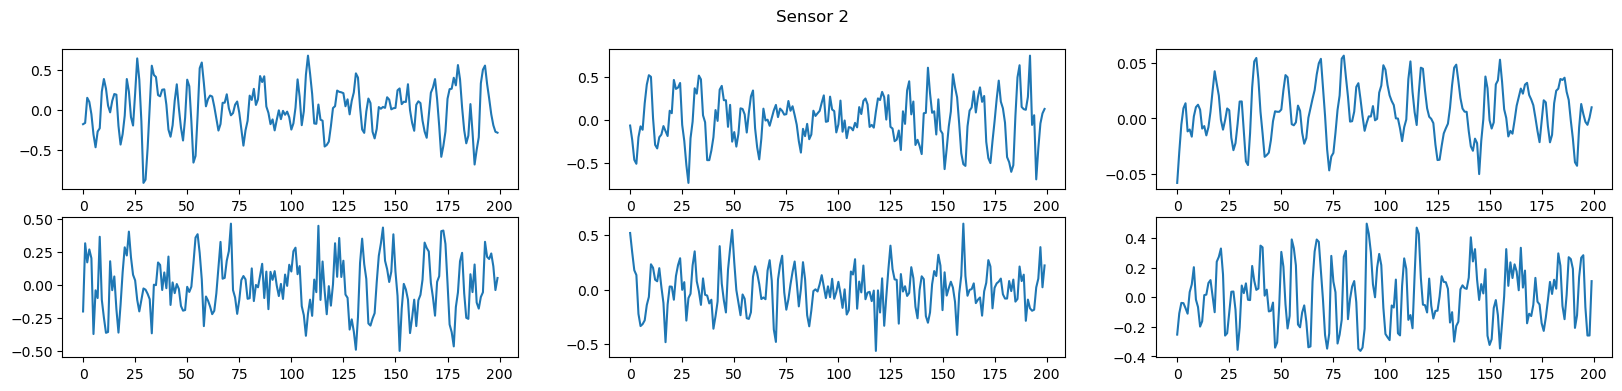

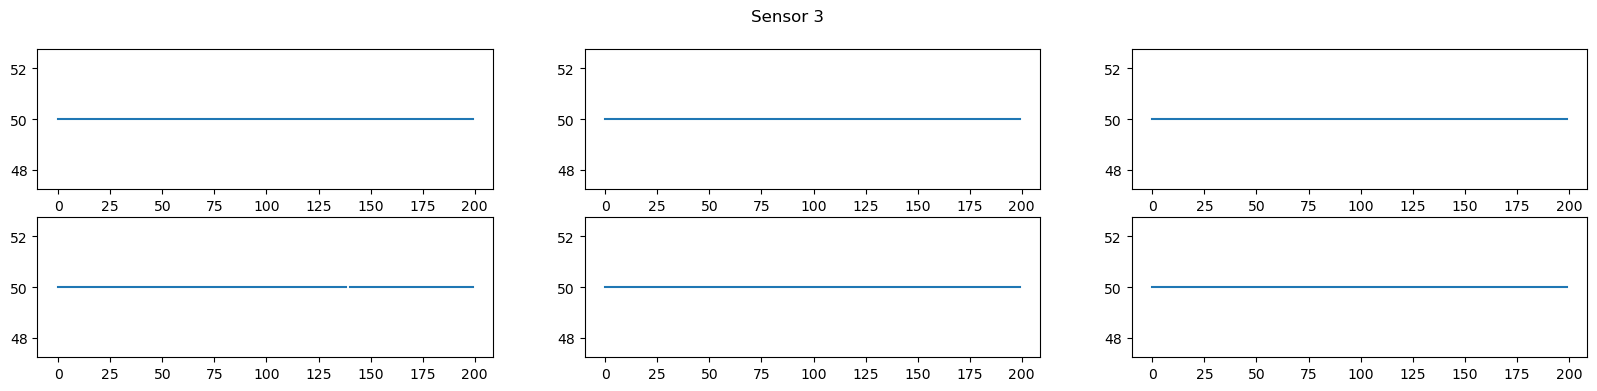

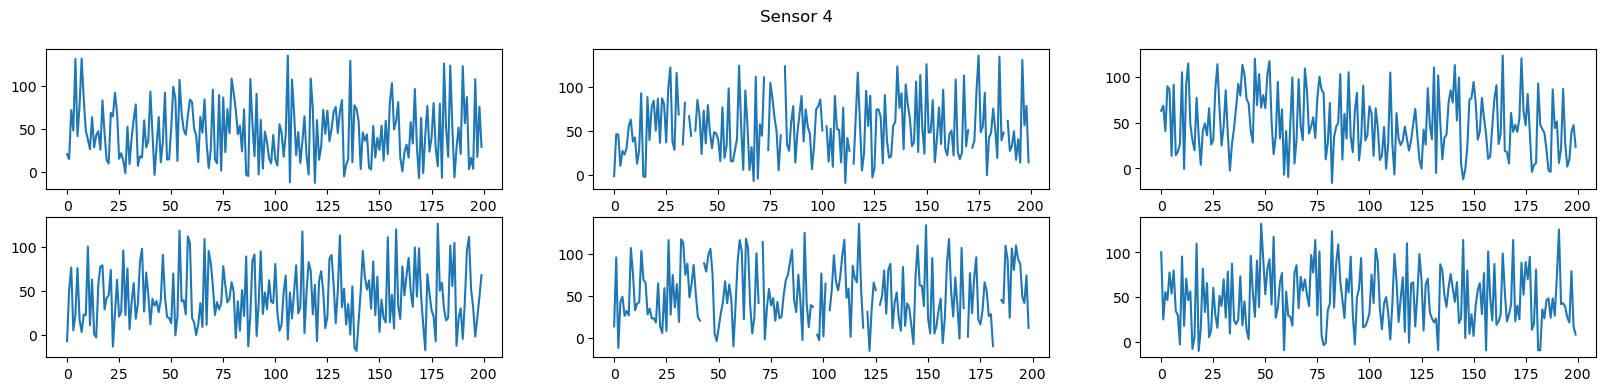

In [7]:
for i in range(n_sensors):
    plot.plot_sig_matrix(f'Sensor {i}', sensor_data[i])

In [8]:
tmp = sensor_data[3].flatten()
tmp = tmp[~np.isnan(tmp)]
tmp = tmp[~np.isclose(tmp, 50.)]
print(tmp)

[]


## Sobre os dados observados:
* Os sensores 0, 1, 2 e 4 parecem conter alguma forma de onda capturada no tempo
    * Assumindo que NaN são falhas no sensor de entrada, optei por preencher os gaps dos dados com um processo de interpolação
* Sobre o Sensor 3: Após observar as ondas e fazer um pequeno estudo, observou-se que ele só contém valores 50 ou NaN
    * Não há informações para concluir que NaN é um valor esperado, ou uma falha de leitura. 
    * Vou descartar os dados desse sensor para a evolução dos estudos

# Tratamento dos dados
* Remover sensor 4 e preencher gaps


In [9]:
n_sensors = 4
sensor_data.pop(3)

array([[50., 50., 50., ..., 50., 50., 50.],
       [50., 50., 50., ..., 50., 50., 50.],
       [50., 50., 50., ..., 50., 50., 50.],
       ...,
       [50., 50., 50., ..., 50., 50., 50.],
       [50., 50., 50., ..., 50., 50., 50.],
       [50., 50., 50., ..., 50., 50., 50.]])

In [10]:
for i in range(n_sensors):
    for j in range(n_samples):
        sensor_data[i][j] = dataP.fill_the_gaps(sensor_data[i][j])

# Coleta e Estudo de Features
* Coletar features básicas sobre os sinais:
    * RMS, peak, peak2peak, crista

In [11]:
n = 200
freq = 10000
time = 1/freq;
rms_global = []
peak = []
peak2peak =[]
crista = []
for i, s_data in enumerate(sensor_data):
    rms_global.append(dataP.get_RMS(s_data, freq, n, n))
    peak.append(np.max(sensor_data[i], axis=1))
    crista.append(peak[i]/rms_global[i][:,0])
    peak2peak.append(np.max(sensor_data[i], axis=1)-np.min(sensor_data[i], axis=1))

## Distribuições por classe

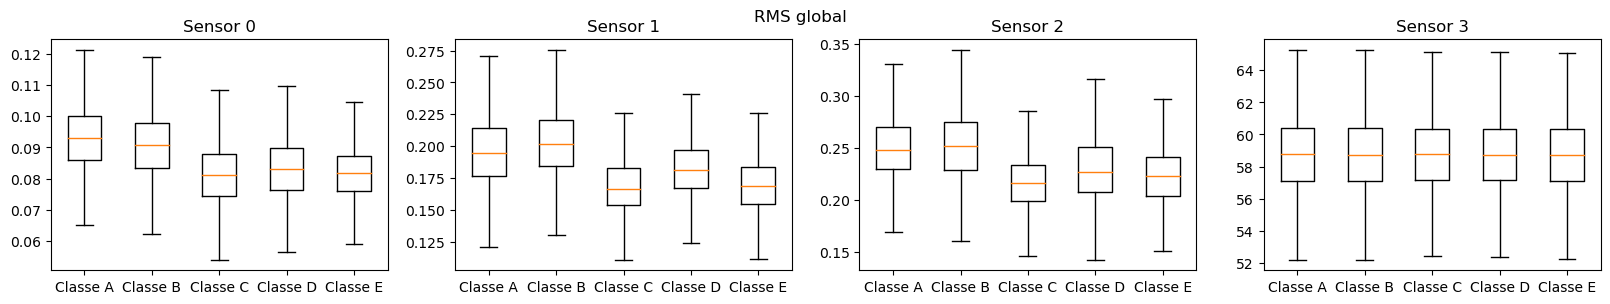

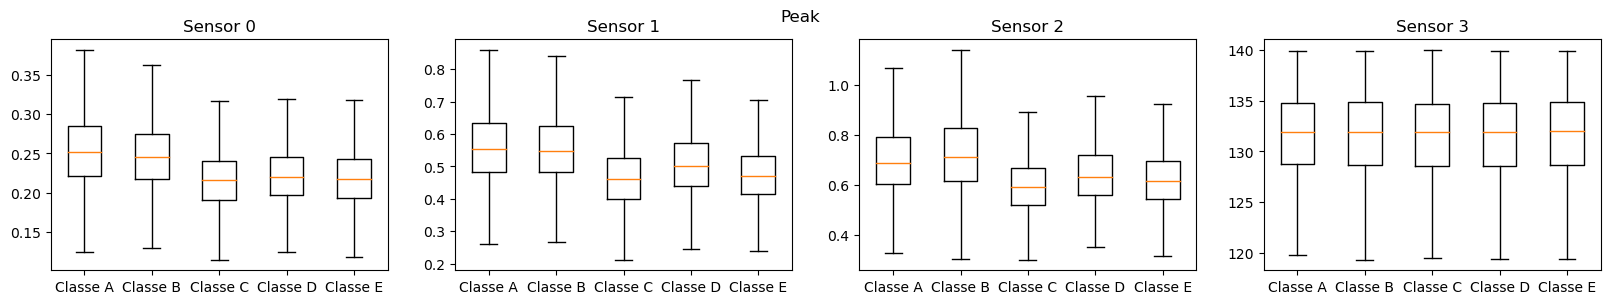

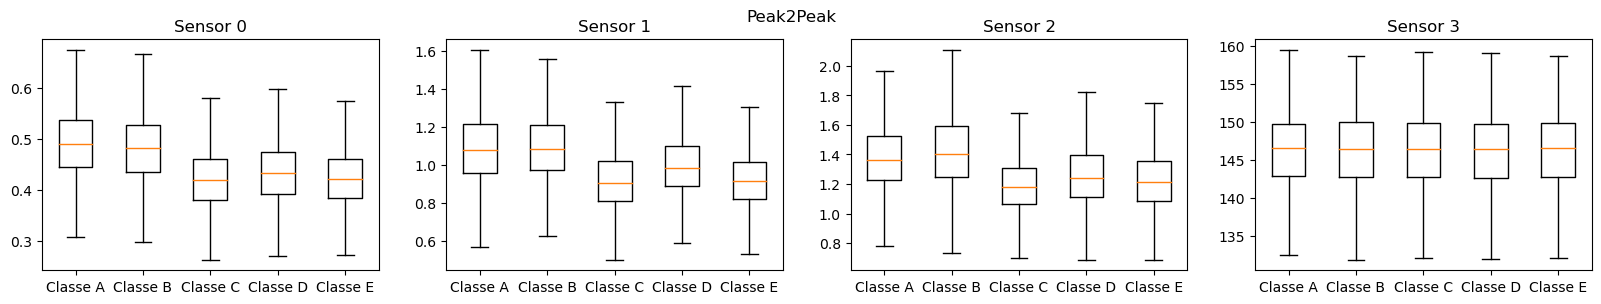

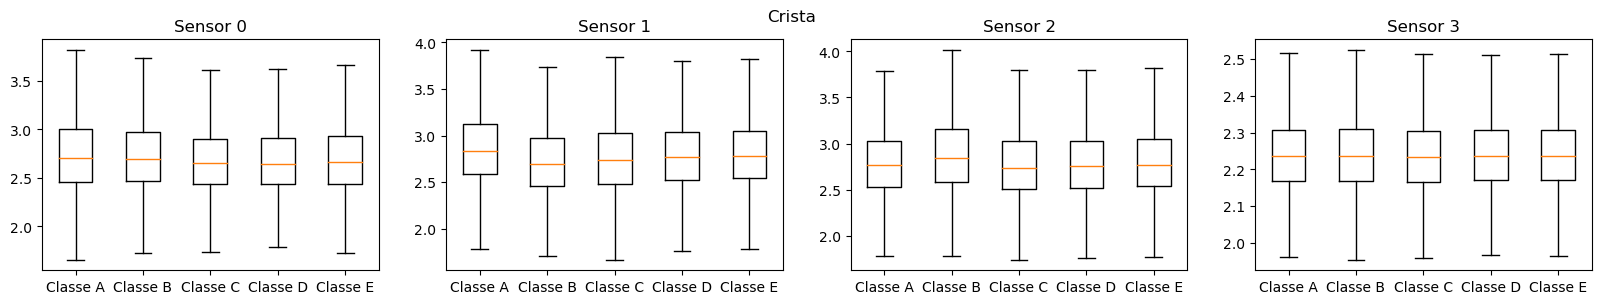

In [12]:
class_filter = {}
for ck in classes_k:
    class_filter[ck] = (classes_data==ck).flatten()

plot.plot_distributions_per_class("RMS global", rms_global, class_filter)
plot.plot_distributions_per_class("Peak", peak, class_filter)
plot.plot_distributions_per_class("Peak2Peak", peak2peak, class_filter)
plot.plot_distributions_per_class("Crista", crista, class_filter)

### Avaliação
* As features coletadas dos sensores 0, 1 e 2 parecem conter alguma informação relevante para as classes
* As features do sensor 3 Parecem não conter qualquer dado útil para diferenciar as classes
    * Não usarei as features coletadas do sensor 3

#### Sobre o Range das features...
* Existe um problema importante que não foi mencionado na descrição do projeto:
    * Não há qualquer indicativo de quais são os ranges de valores que podem ser representados pelos sensores.
    * Se eu tivesse essa informação, ela seria extremamente útil para pré-calcular os valores que podem ser utilizados para as normalizações]
    * Como não estão disponíveis, vou inferir com base nos dados apresentados e salvar essa info para utilização futura

In [20]:
file = './norm_feat_params.json'
metrics = ["RMS", "Peak", "Peak2Peak", "Crista"]
limits_map = {m:{f's{i}': [] for i in range(n_sensors-1)} for m in metrics} #ignorar sensor 4
for m_label, m_data in zip(metrics, [rms_global, peak, peak2peak, crista]):
    for i in range(n_sensors-1):#ignorar sensor 4
        min_v, max_v = np.min(np.min(m_data[i])), np.max(np.max(m_data[i]))
        print(m_label, i, min_v, max_v)
        print(m_data)
        limits_map[m_label][f's{i}'] = [min_v, max_v]

with open(file, 'w') as fout:
    json_dumps_str = json.dumps(limits_map, indent=4)
    print(json_dumps_str, file=fout)

RMS 0 0.001423178407647945 0.3707128713504038
[array([[0.09626256],
       [0.09935984],
       [0.01194225],
       ...,
       [0.09220206],
       [0.09908269],
       [0.08942733]]), array([[0.16202019],
       [0.21230577],
       [0.0237321 ],
       ...,
       [0.20003535],
       [0.19569352],
       [0.21004499]]), array([[0.28399399],
       [0.27545054],
       [0.02421747],
       ...,
       [0.25924754],
       [0.26483993],
       [0.24792912]]), array([[57.32883799],
       [62.38221376],
       [59.24190561],
       ...,
       [61.42733613],
       [58.76573523],
       [62.21377966]])]
RMS 1 0.0010067977406740408 0.41489146360397355
[array([[0.09626256],
       [0.09935984],
       [0.01194225],
       ...,
       [0.09220206],
       [0.09908269],
       [0.08942733]]), array([[0.16202019],
       [0.21230577],
       [0.0237321 ],
       ...,
       [0.20003535],
       [0.19569352],
       [0.21004499]]), array([[0.28399399],
       [0.27545054],
       [0.024217

# Domínio de frequências

In [17]:
fft_ys = []
fft_lims = {f's{i}':0 for i in range(n_sensors)}
for i, s_data in enumerate(sensor_data):
    xfs, yfs = dataP.apply_fft(s_data, freq, n)
    max_v = np.max(np.max(yfs))
    fft_lims[f's{i}'] = max_v
    fft_ys.append(yfs/max_v)
    xfs = xfs/np.max(xfs)

In [18]:
file = './norm_freq_params.json'
with open(file, 'w') as fout:
    json_dumps_str = json.dumps(fft_lims, indent=4)
    print(json_dumps_str, file=fout)

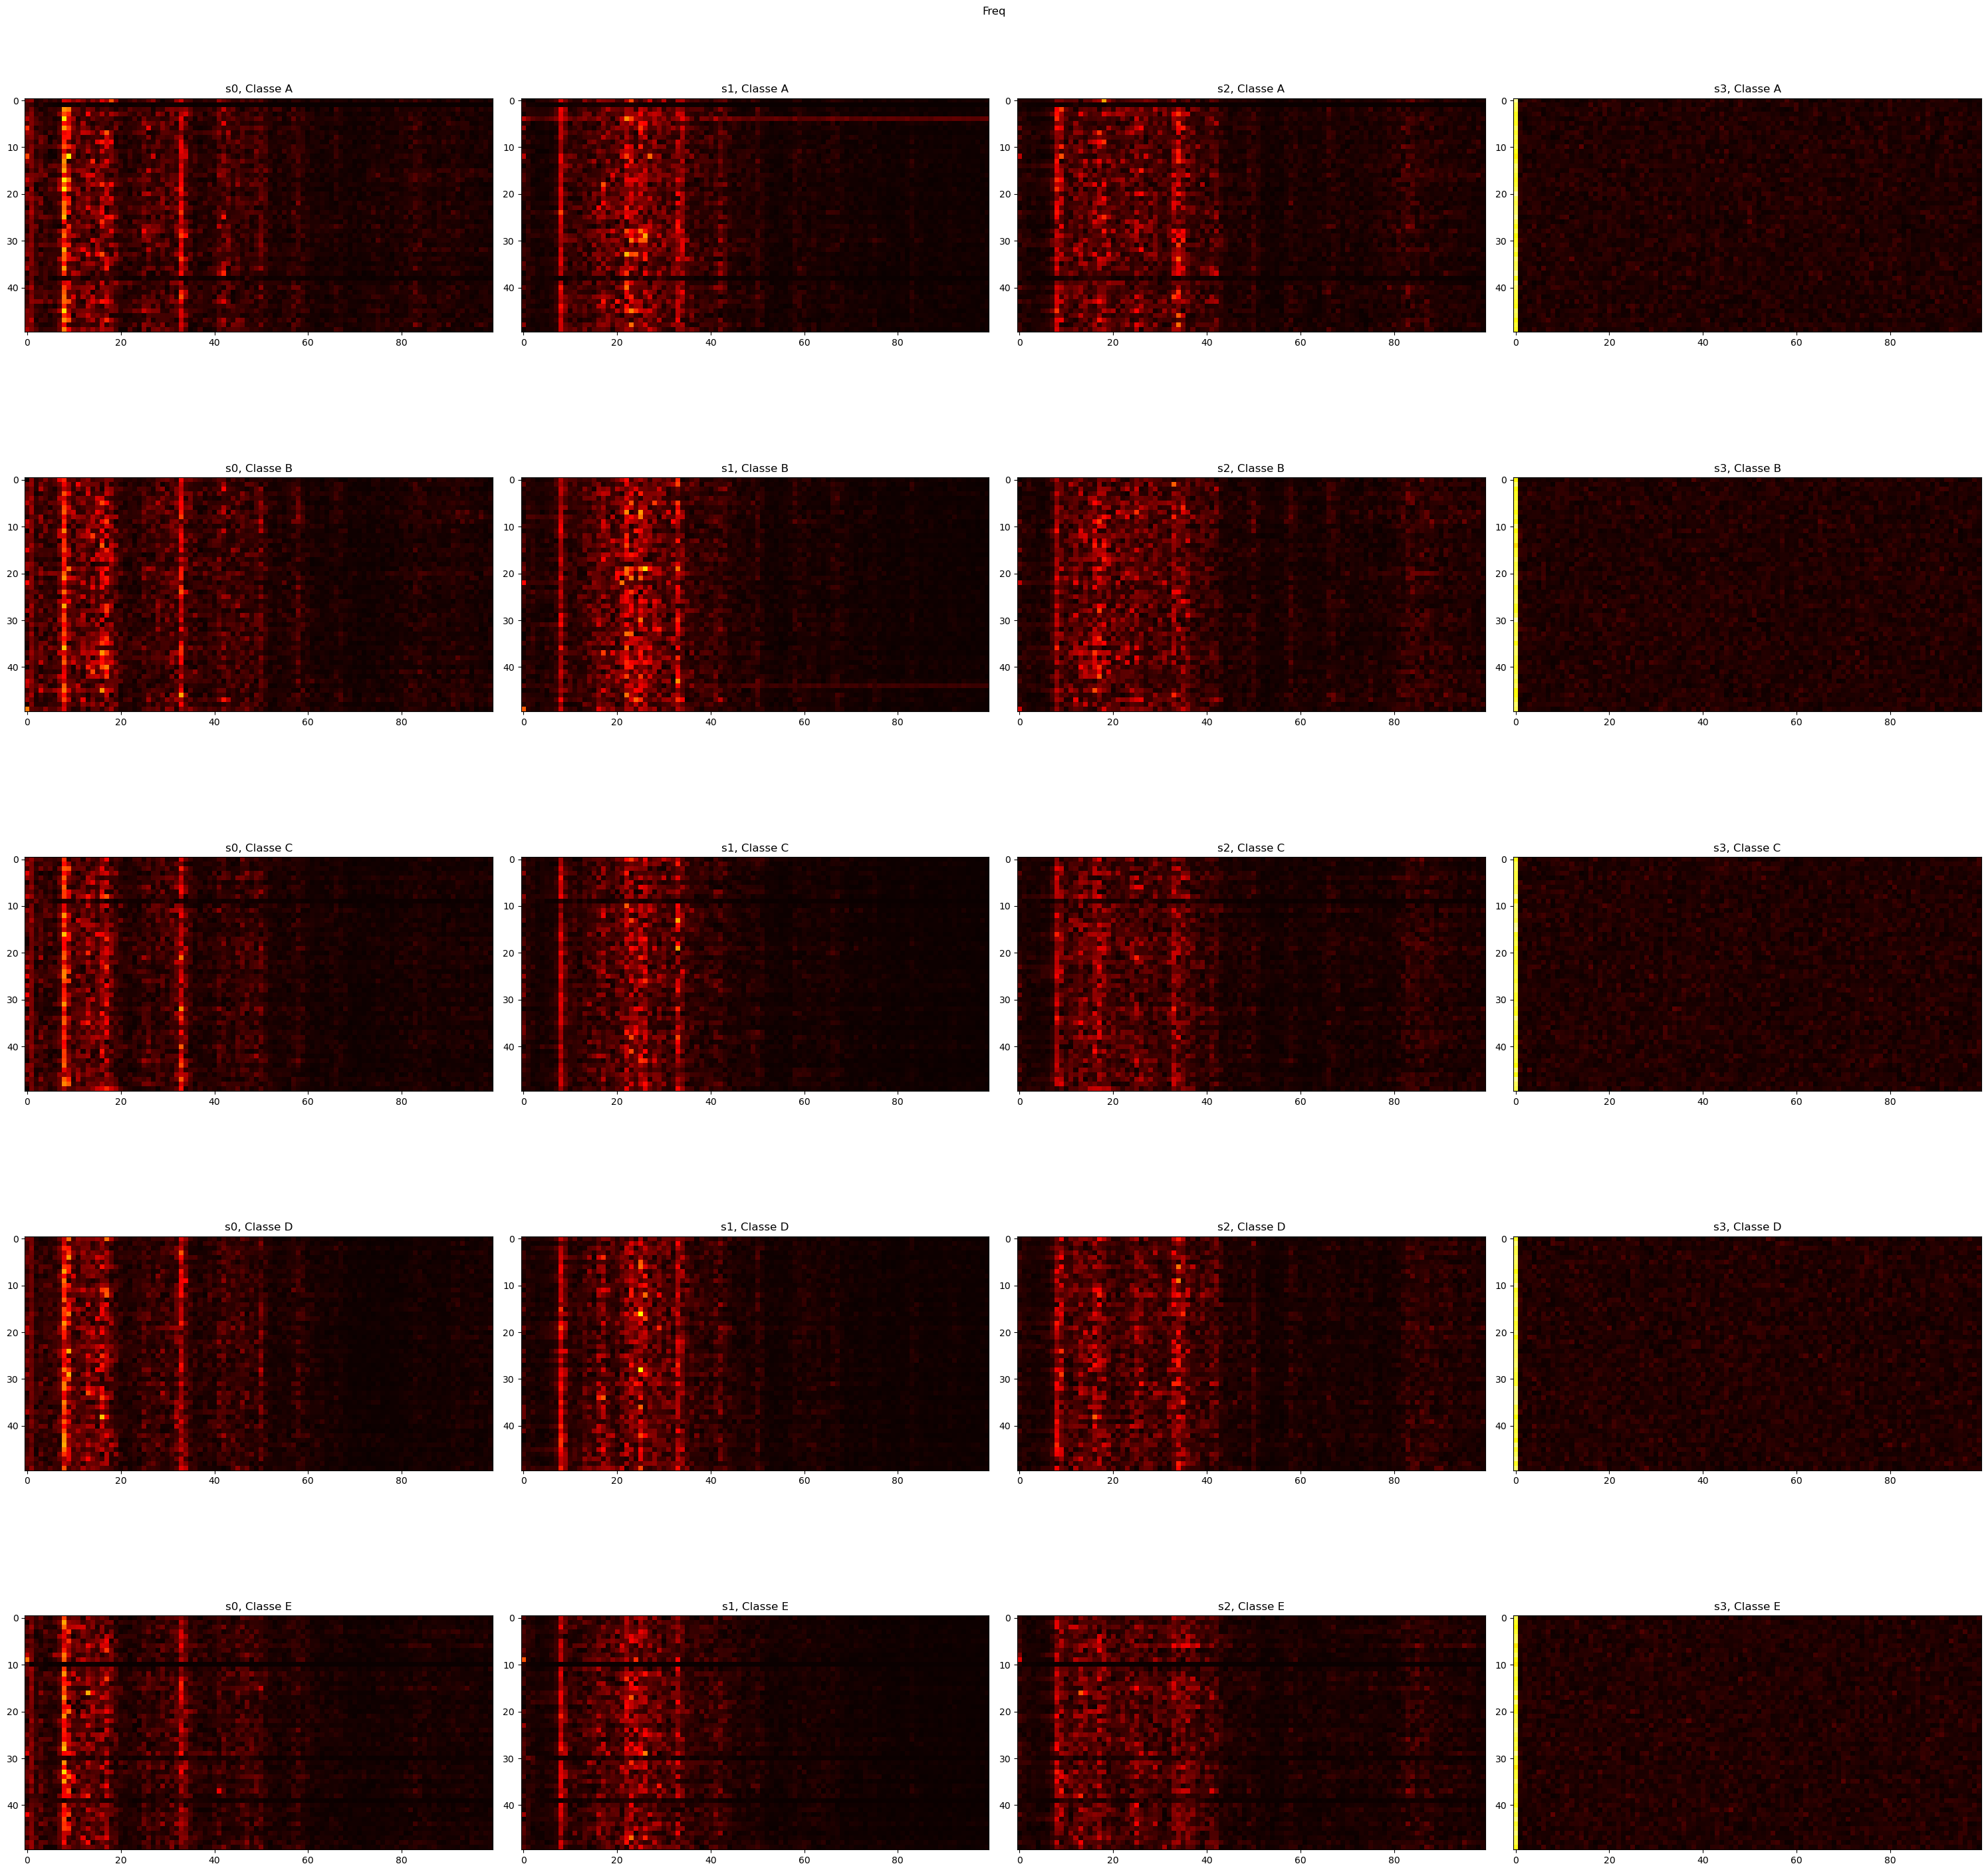

In [16]:
plot.plot_freq_samples("Freq", fft_ys, class_filter)

* Frequências possuem informações muito relevantes sobre um sinal
    * Sei que existe a caracterização de tipos de falhas considerando picos e amplitudes específicas
    * Também sei que é possível filtrar ruído de um sinal processando as frequências
    * Eu não tenho qualquer informação sobre o que são esses sensores:
        * Qual é o modo de operação normal?
        * Como as vibrações evoluem ao longo do tempo de operação?
        * O que é esse resultado do sensor 3 com um DC extremamente elevado e com um valor que parece ser apenas ruído no restante das frequências?
    * Vou alimentar esses dados para uma MLP para que ela encontre os padrões entre os sinais e classes